In [68]:
import numpy as np
import scipy.stats
import torch
import matplotlib.pyplot as plt
confidence = 0.95
class Value:
	'''A measured or calculated value, with uncertainty.'''
	def __init__(self, value, uncertainty=0):
		self.value = float(value)
		self.uncertainty = float(uncertainty)

	def __str__(self) -> str:
		return f'{self.value} ± {self.uncertainty}'

	def __repr__(self) -> str:
		return f'Value({self.value}, {self.uncertainty})'

	def relative_uncertainty(self) -> float:
		'''calculate the relative uncertainty'''
		return self.uncertainty / self.value

In [69]:
def margin_of_error(value : np.array) -> float:
	'''calculate Margin of Error (the uncertainty associated with random error), using the t-distribution'''
	return scipy.stats.t.ppf((1 + confidence) / 2, len(value) - 1) * np.std(value, ddof=1) / np.sqrt(len(value))

def measure(value : np.array, tolerance=0, factor=1, intercept=0) -> Value:
	'''measure a value with uncertainty, assuming the data is uniformly distributed within the tolerance'''
	systematic_error = tolerance * confidence
	if hasattr(value, '__len__'):
		ME = margin_of_error(value)
		return Value((np.mean(value) - intercept) * factor, np.sqrt(ME**2 + systematic_error**2) * factor)
	else:
		return Value((value - intercept) * factor, systematic_error * factor)

def calc(f, *args : float | Value) -> Value:
	'''calculate a function with uncertainty, using torch'''
	# Convert all arguments to torch tensors
	values = [
		torch.tensor(
			arg.value if isinstance(arg, Value) else arg,
			requires_grad=True,
			dtype=float
		)
		for arg in args
	]
	uncertainties = [torch.tensor(arg.uncertainty if isinstance(arg, Value) else 0) for arg in args]

	# Calculate the function value
	value : torch.Tensor = f(*values)

	# Calculate the uncertainty using the formula for error propagation
	value.backward()
	uncertainties = torch.Tensor([(uncertainty * value.grad) for uncertainty, value in zip(uncertainties, values)])
	uncertainty = torch.sqrt(torch.sum(uncertainties ** 2))
	calc.uncertainties = torch.abs(uncertainties)

	return Value(value.detach().numpy(), uncertainty.detach().numpy())

# Experiment 6 - Measuring the focal length

In [70]:
x_0_original = np.array([4.40, 10.05])
x_0_delta = 2.296
x_0 = measure(x_0_original.mean(), tolerance=0.05, intercept=-x_0_delta)
x_0	# light source position

Value(9.521, 0.0475)

## 1. Convex lens - Self-collimation method

In [71]:
x = [
	[
		[
			[23.55, 23.90, 23.90], # 1, ->, l
			[28.40, 28.85, 28.80], # 1, ->, r
		],
		[
			[23.55, 23.70, 23.90], # 1, <-, l
			[28.40, 28.60, 28.80], # 1, <-, r
		],
	],
	[
		[
			[23.30, 23.50, 23.25], # 2, ->, l
			[28.15, 28.40, 28.30], # 2, ->, r
		],
		[
			[23.45, 23.35, 23.25], # 2, <-, l
			[28.20, 28.70, 28.65], # 2, <-, r
		]
	]
]
x = np.array(x)

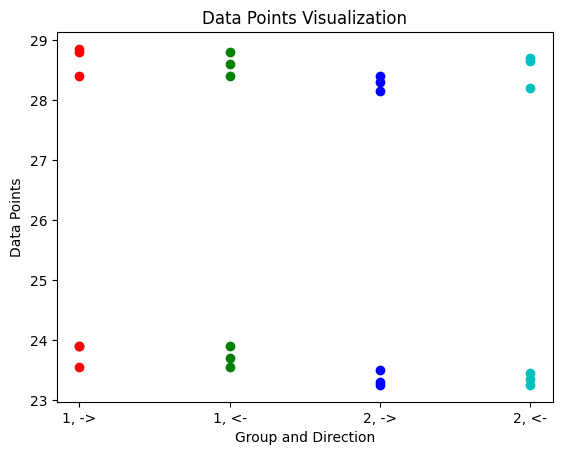

In [72]:
# plot every data point of x on a axis, marking the different groups with different colors

# Setting up color map for different groups
colors = ['r', 'g', 'b', 'c']  # Four different groups

# Plotting
for i in range(x.shape[0]):  # Loop over the first dimension (2 groups)
    for j in range(x.shape[1]):  # Loop over the second dimension (left, right)
        for k in range(x.shape[2]):  # Loop over the third dimension (l, r)
            data_points = x[i, j, k, :]
            plt.scatter([i*2 + j]*len(data_points), data_points, color=colors[i*2 + j])

plt.xlabel('Group and Direction')
plt.ylabel('Data Points')
plt.title('Data Points Visualization')
plt.xticks(ticks=np.arange(4), labels=['1, ->', '1, <-', '2, ->', '2, <-'])
plt.show()

In [73]:
# Grouping the data points
x_1_l = measure(x[0, :, 0, :].flatten(), tolerance=0.05)
x_1_r = measure(x[0, :, 1, :].flatten(), tolerance=0.05)
x_2_l = measure(x[1, :, 0, :].flatten(), tolerance=0.05)
x_2_r = measure(x[1, :, 1, :].flatten(), tolerance=0.05)
print(
	f'x_1_l = {x_1_l}',
	f'x_1_r = {x_1_r}',
	f'x_2_l = {x_2_l}',
	f'x_2_r = {x_2_r}',
	sep='\n'
)

x_1_l = 23.75 ± 0.18787151166067637
x_1_r = 28.641666666666666 ± 0.2212924946063544
x_2_l = 23.349999999999998 ± 0.11987792454970558
x_2_r = 28.400000000000002 ± 0.24622338159784937


In [74]:
def f1(x_1_l, x_1_r, x_2_l, x_2_r, x_0):
	# return the mean of the data points
	return (x_1_l + x_1_r + x_2_l + x_2_r) / 4 - x_0
f = calc(f1, x_1_l, x_1_r, x_2_l, x_2_r, x_0)
print(f'f = {f}, {f.relative_uncertainty()}')

f = 16.514416666666666 ± 0.11049965023994446, 0.006691102233297844


## 2. Convex Lens - Conjugate Method

In [75]:
x_0_prime_original = np.array([84.30, 89.15])
x_0_prime = measure(x_0_prime_original.mean(), tolerance=0.05)
x_0_prime	# image position

Value(86.725, 0.0475)

In [76]:
x = [
	[
		[31.45, 31.40, 31.50, 31.30, 31.80, 31.60],	# 1, ->
		[30.95, 31.00, 31.20, 31.30, 31.10, 31.15], # 1, <-
	],
	[
		[59.25, 59.50, 59.20, 59.00, 59.15, 59.30],	# 2, ->
		[58.90, 59.00, 59.40, 59.00, 59.10, 59.25], # 2, <-
	]
]
x = np.array(x)

x_1_-> = 31.50833333333333 ± 0.18908883153596306
x_1_<- = 31.11666666666667 ± 0.1435670669711704
x_2_-> = 59.23333333333333 ± 0.18090320481696653
x_2_<- = 59.10833333333334 ± 0.200399218721343


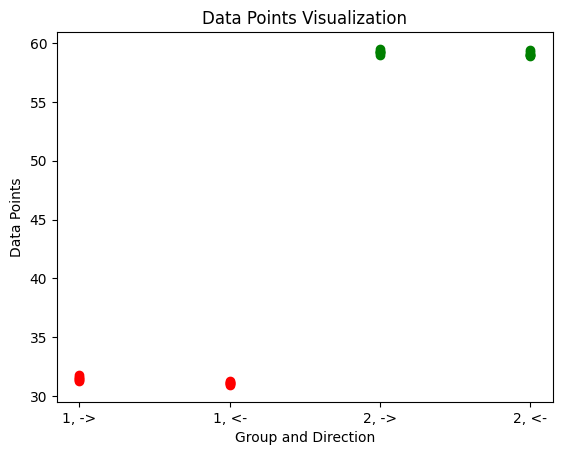

In [77]:
# plot every data point of x on a axis, marking the different groups with different colors
# Setting up color map for different groups
colors = ['r', 'g']  # Two different groups

# Plotting
for i in range(x.shape[0]):  # Loop over the first dimension (2 groups)
    for j in range(x.shape[1]):  # Loop over the second dimension (->, <-)
        data_points = x[i, j, :]
        plt.scatter([i*2 + j]*len(data_points), data_points, color=colors[i])
        # print mean and standard deviation
        print(f'x_{i+1}_{"->" if j == 0 else "<-"} = {measure(data_points, tolerance=0.05)}')

plt.xlabel('Group and Direction')
plt.ylabel('Data Points')
plt.title('Data Points Visualization')
plt.xticks(ticks=np.arange(4), labels=['1, ->', '1, <-', '2, ->', '2, <-'])
plt.show()

In [78]:
x_1_L = measure(x[0, 0, :], tolerance=0.05)
x_1_R = measure(x[0, 1, :], tolerance=0.05)
x_2_L = measure(x[1, 0, :], tolerance=0.05)
x_2_R = measure(x[1, 1, :], tolerance=0.05)

def calc_d(x_1_L, x_1_R, x_2_L, x_2_R):
	d = ((x_2_L + x_2_R) - (x_1_L + x_1_R)) / 2
	return d
def calc_D(x_0, x_0_prime):
	D = x_0_prime - x_0
	return D
def calc_f(x_1_L, x_1_R, x_2_L, x_2_R, x_0, x_0_prime):
	d = calc_d(x_1_L, x_1_R, x_2_L, x_2_R)
	D = calc_D(x_0, x_0_prime)
	f = (D ** 2 - d ** 2) / (4 * D)
	return f
d = calc(calc_d, x_1_L, x_1_R, x_2_L, x_2_R)
print(f'd = {d}')
D = calc(calc_D, x_0, x_0_prime)
print(f'D = {D}')
f = calc(calc_f, x_1_L, x_1_R, x_2_L, x_2_R, x_0, x_0_prime)
print(f'f = {f}, {f.relative_uncertainty()}')

d = 27.858333333333334 ± 0.17975811660289764
D = 77.204 ± 0.06717514246702194
f = 16.787895963579892 ± 0.03757781162858009, 0.002238387211244482


## 3. Convex Lens - Conjugate Method via Displacement Method

In [79]:
x = [
	[31.50, 31.20, 30.75], # 1
	[58.70, 59.60, 59.20], # 2
]
x = np.array(x)

In [80]:
x_1 = measure(x[0, :], tolerance=0.05)
x_2 = measure(x[1, :], tolerance=0.05)
print(f'x_1 = {x_1}')
print(f'x_2 = {x_2}')
def calc_d(x_1, x_2):
	d = (x_2 - x_1) / 2
	return d
def calc_D(x_0, x_0_prime):
	D = x_0_prime - x_0
	return D
def calc_f(x_1, x_2, x_0, x_0_prime):
	d = calc_d(x_1, x_2)
	D = calc_D(x_0, x_0_prime)
	f = (D ** 2 - d ** 2) / (4 * D)
	return f
d = calc(calc_d, x_1, x_2)
print(f'd = {d}')
D = calc(calc_D, x_0, x_0_prime)
print(f'D = {D}')
f = calc(calc_f, x_1, x_2, x_0, x_0_prime)
print(f'f = {f}, {f.relative_uncertainty()}')


x_1 = 31.150000000000002 ± 0.938943674788384
x_2 = 59.166666666666664 ± 1.1211663948104256
d = 14.008333333333331 ± 0.7312026619911194
D = 77.204 ± 0.06717514246702194
f = 18.6655620603279 ± 0.06856731325387955, 0.0036734663029308755


## 4. Concave lens - Object distance-image distance method

In [82]:
x_1_original = [
	[84.10, 84.30, 83.90],	# <-
	[84.00, 84.20, 83.80],	# ->
]
x_1_original = np.array(x_1_original).flatten()
x_1_original = measure(x_1_original, tolerance=0.05)
x_1_delta_original = measure(
	[88.90 - 84.10, 88.90 - 84.00], tolerance=0.05
	)
x_1 = calc(lambda x, y: x + y / 2, x_1_original, x_1_delta_original)
print(f'x_1 = {x_1}')

x_1 = 86.475 ± 0.37718844413757324


In [83]:
x_2_original = np.array([106.85, 111.70])
x_2 = measure(x_2_original.mean(), tolerance=0.05)
print(f'x_2 = {x_2}')

x_2 = 109.275 ± 0.0475


In [84]:
x_3_original = [
	[
		[71.40, 71.00, 71.20],	# 1, ->
		[71.10, 71.15, 71.20],	# 1, <-
	],
	[
		[71.45, 71.10, 71.15],	# 2, ->
		[70.90, 70.80, 70.90],	# 2, <-
	]
]
x_3_original = np.array(x_3_original)
x_3_delta_original = [
	76.30 - 71.40,
	76.00 - 71.10,
	76.35 - 71.45,
	75.80 - 70.90,
]
x_3_delta = measure(x_3_delta_original, tolerance=0.05)
print(f'x_3_delta = {x_3_delta}')
x_3_l_L = measure(x_3_original[:, 0, :].flatten(), tolerance=0.05)
print(f'x_3_l_-> = {x_3_l_L}')
x_3_l_R = measure(x_3_original[:, 1, :].flatten(), tolerance=0.05)
print(f'x_3_l_<- = {x_3_l_R}')
x_3 = calc(lambda x, y, z: (x + y) / 2 + z / 2, x_3_l_L, x_3_l_R, x_3_delta)
print(f'x_3 = {x_3}')

x_3_delta = 4.899999999999995 ± 0.0475
x_3_l_-> = 71.21666666666665 ± 0.18981547619310993
x_3_l_<- = 71.00833333333334 ± 0.17705740752407584
x_3 = 73.5625 ± 0.13194268941879272


In [86]:
def calc_f(x_1, x_2, x_3):
	s_1 = x_3 - x_1
	s_2 = x_2 - x_3
	# 1 / f = 1 / s_1 + 1 / s_2
	# => f = 1 / (1 / s_1 + 1 / s_2)
	f = 1 / (1 / s_1 + 1 / s_2)
	return f
f = calc(calc_f, x_1, x_2, x_3)
print(f'f = {f}, {f.relative_uncertainty()}')
calc.uncertainties

f = -20.225335800438582 ± 0.9673556089401245, -0.047828902248394194


tensor([0.9254, 0.0152, 0.2814])